In [2]:
# Transformer代码实现，框架见思维导图
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
# 整体框架和输出生成器
class EncoderDecoder(nn.Module):
    # 基础的encoder、decoder架构
    def __init__(self, encoder, decoder, src_embd, tgt_embd, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embd = src_embd
        self.tgt_embd = tgt_embd
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        # 接收masked src和target sequences
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embd(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embd(tgt), memory, src_mask, tgt_mask)
    

class Generator(nn.Module):
    # 生成器，由Linear和softmax组成
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [4]:
# Encoder层 N=6个完全相同的编码器组成
def clones(module, N):
    # 产生N个完全相同的单元
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        # 每一层输入都是x和mask
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x) # 输出到解码器前进行LayerNorm标准化

In [7]:
# 每个子层都需要残差和标准化，下面实现LayerNorm 依据公式
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # 使得a_2,b_2成为模型的可学习参数
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # keepdim 保留目标维度，例如一个4*4的向量处理后得到4*1而非1*4
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [8]:
# 每个子层的输出是LayerNorm(x + SubLayer(x)), dropout加在SubLayer上
# 设置所有embedding和子层输出维度都是dmodel = 512
# 下面的SublayerConnection类用来处理单个Sublayer输出，并接着输入到下一个Sublayer
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
# 编码器有两个子层：1.多头自注意力层；2.FNN
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        # size 是d_model 论文中为512，self_attn,feed_forward是encoder对应的自注意力层和fnn层
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # self-attention层
        return self.sublayer[1](x, self.feed_forward) # fnn

In [10]:
# 解码器也是由6个完全相同的decoder层组成
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [11]:
# decoder子层和encoder子层不同的是，有第三个子层，该层对encoder输出执行attention：即encoder-decoder-attention层
# q向量来自decoder上一层输出，k和v向量是encoder最后层的输出。同样也会残差和norm
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        self.src_attn = src_attn
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # self-attention层
        x = self.sublayer[1](x, lambda x: self.self_attn(x, m, m, src_mask)) # encoder-decoder attention层
        return self.sublayer[2](x, self.feed_forward) # fnn

In [12]:
# 对于DecoderLayer中的self-attention层，需要使用mask防止看到后面的位置
def subsequent_mask(size):
    attn_shape = (1, size, size)
    # np.triu(a, k)是取矩阵a的上三角数据，但这个三角的斜线位置由k的值确定。 k=1说明对角线往上移动一个单元 -1则往下移动
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

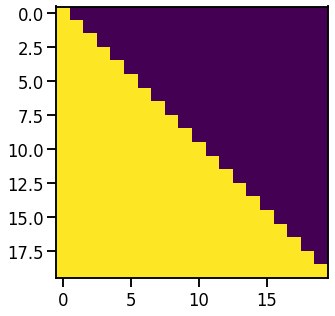

In [13]:
# 下面的attention mask显示了每个tgt单词（行）允许查看（列）的位置。在训练时将当前单词的未来信息屏蔽掉，阻止此单词关注到后面的单词。
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [14]:
# 注意力实现
def attention(query, key, value, mask=None, dropout=None):
    # Scaled Dot Production Attention
    d_k = query.size(-1)
    ##首先经过matmul函数得到的scores形状是 : [batch_size x n_heads x len_q x len_k]
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 转置倒数两维度 使得[len_q, d_k] * [d_k, len_k] = [len_q, len_k]
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

除了缩放因子，点积Attention跟我们的平时的点乘算法一样。加法attention使用具有单个隐层的前馈网络计算相似度。虽然理论上点积attention和加法attention复杂度相似，但在实践中，点积attention可以使用高度优化的矩阵乘法来实现，因此点积attention计算更快、更节省空间。
当dk的值比较小的时候，这两个机制的性能相近。当dk比较大时，加法attention比不带缩放的点积attention性能好。我们怀疑，对于很大的
值, 点积大幅度增长，将softmax函数推向具有极小梯度的区域。(为了说明为什么点积变大，假设q和k是独立的随机变量，均值为0，方差为1。那么它们的点积q·k=Σdk i=1 qi * ki, 均值为0方差为dk)。为了抵消这种影响，我们将点积缩小1/sqrt(dk)倍。

In [15]:
# 实现多头注意力
# 本文采取h=8个平行attention层或head。对每一个head，dk=dv=dmodel/h = 64，由于每个head维度减小，总计算成本和具有全部维度的单个attention相似
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        # 4个矩阵，分别是WQ、WK、WV、W0
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
         # 注意 Q，K，V的在句子长度这一个维度的数值可以一样，可以不一样。
        # K: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # V: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # Q: [64,12,300], 假设batch_size 为 64，有 12 个词，每个词的 Query 向量是 300 维
        if mask is not None:
            # 输入进行的attn_mask形状是 batch_size x len_q x len_k，然后经过下面这个代码得到 新的attn_mask : [batch_size x n_heads x len_q x len_k]，就是把pad信息重复了n个头上
            # 对所有head应用mask
            mask = mask.unsqueeze(1) # 在第二维增加一个维度
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h * d_k  [nbatches, 8, L, 64]
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) # contiguous断开x转置和x的对应关系，实现深拷贝
        return self.linears[-1](x)

## 模型中Attention的应用
multi-head attention在Transformer中有三种不同的使用方式：

1. 在encoder-decoder attention层中，queries来自前面的decoder层，而keys和values来自encoder的输出。这使得decoder中的每个位置都能关注到输入序列中的所有位置。这是模仿序列到序列模型中典型的编码器—解码器的attention机制。
2. encoder包含self-attention层。在self-attention层中，所有key，value和query来自同一个地方，即encoder中前一层的输出。在这种情况下，encoder中的每个位置都可以关注到encoder上一层的所有位置。
3. 类似地，decoder中的self-attention层允许decoder中的每个位置都关注decoder层中当前位置之前的所有位置（包括当前位置）。 为了保持解码器的自回归特性，需要防止解码器中的信息向左流动。我们在缩放点积attention的内部，通过屏蔽softmax输入中所有的非法连接值（设置为）实现了这一点。

## 基于位置的FNN
公式：$$
 FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
 $$

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [17]:
# Embedding 和 Softmax
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码
从零开始构思一个位置编码方法：（来自https://blog.csdn.net/qq_22795223/article/details/105676186?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522163653830）
1.
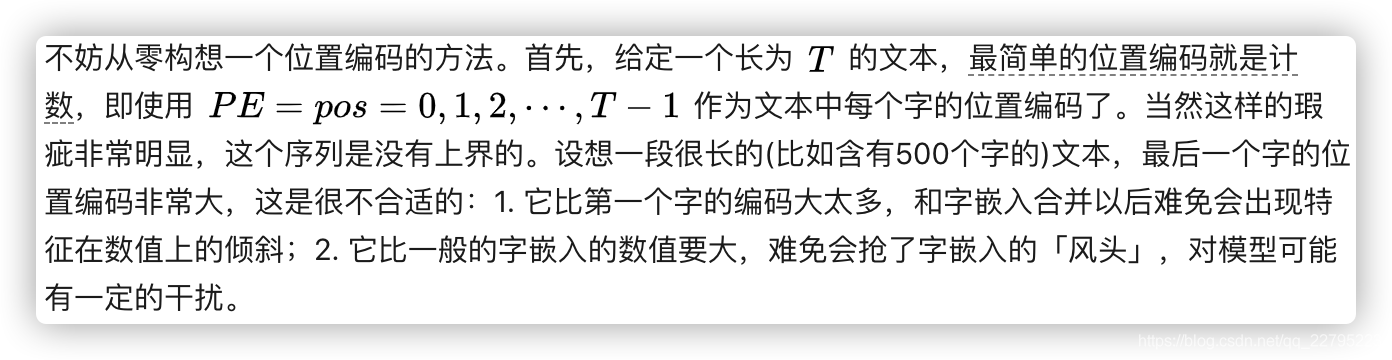
可能导致特征上的倾斜或引入干扰信息

2.
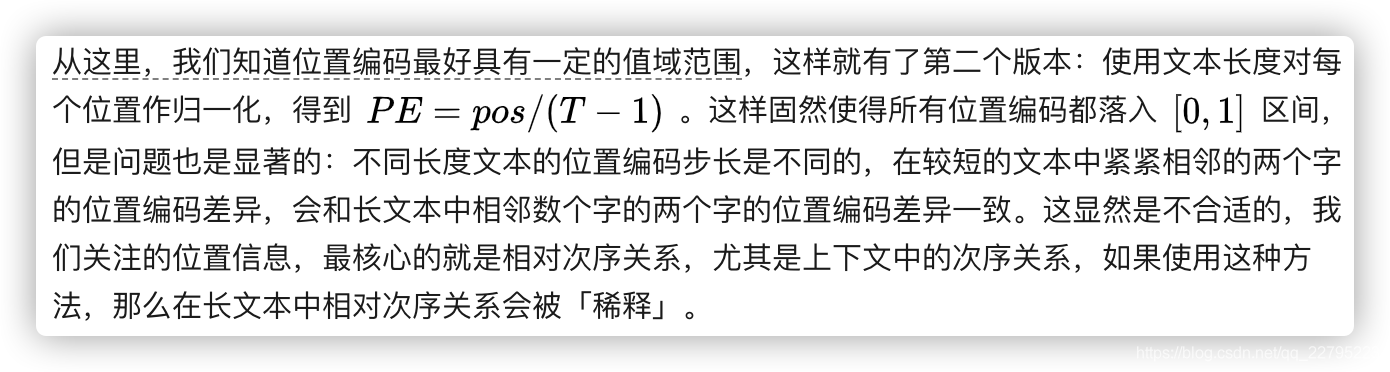
编码步长是个绝对值，会对相对概念造成影响

3.
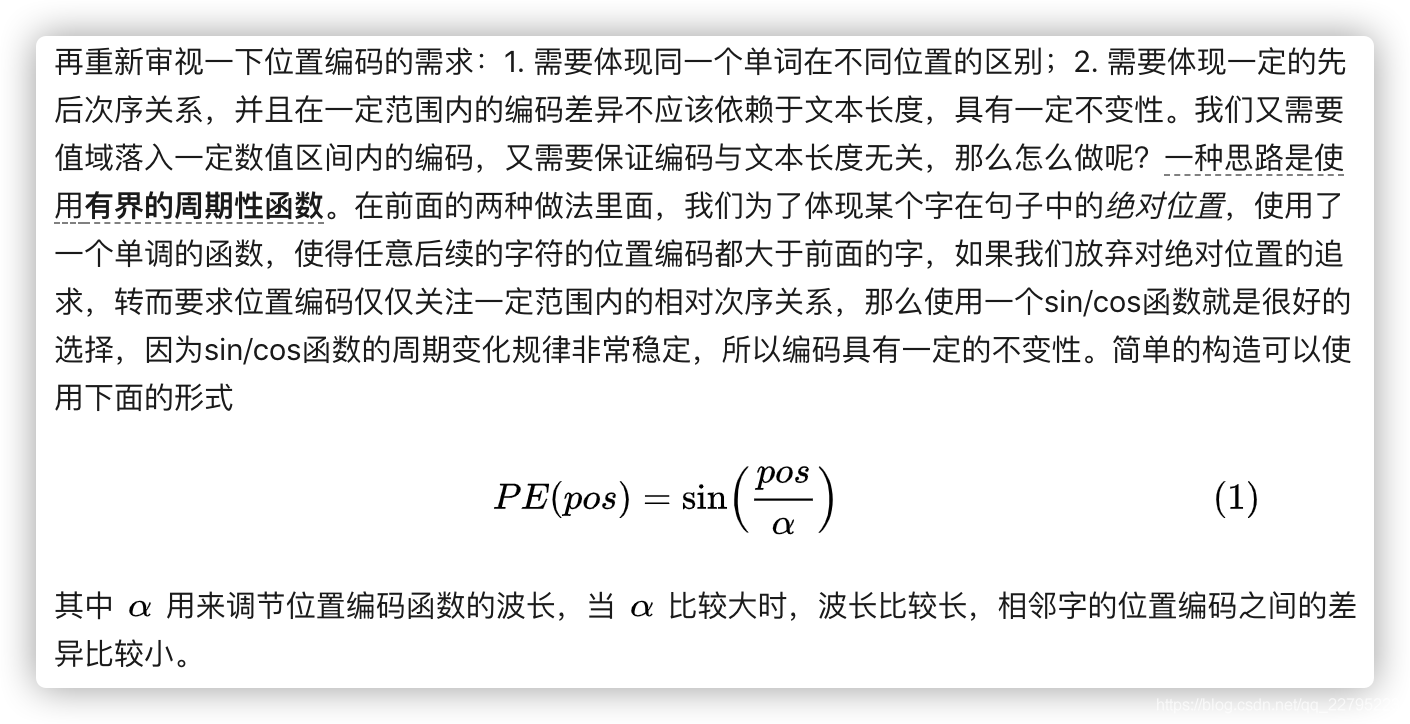

4.
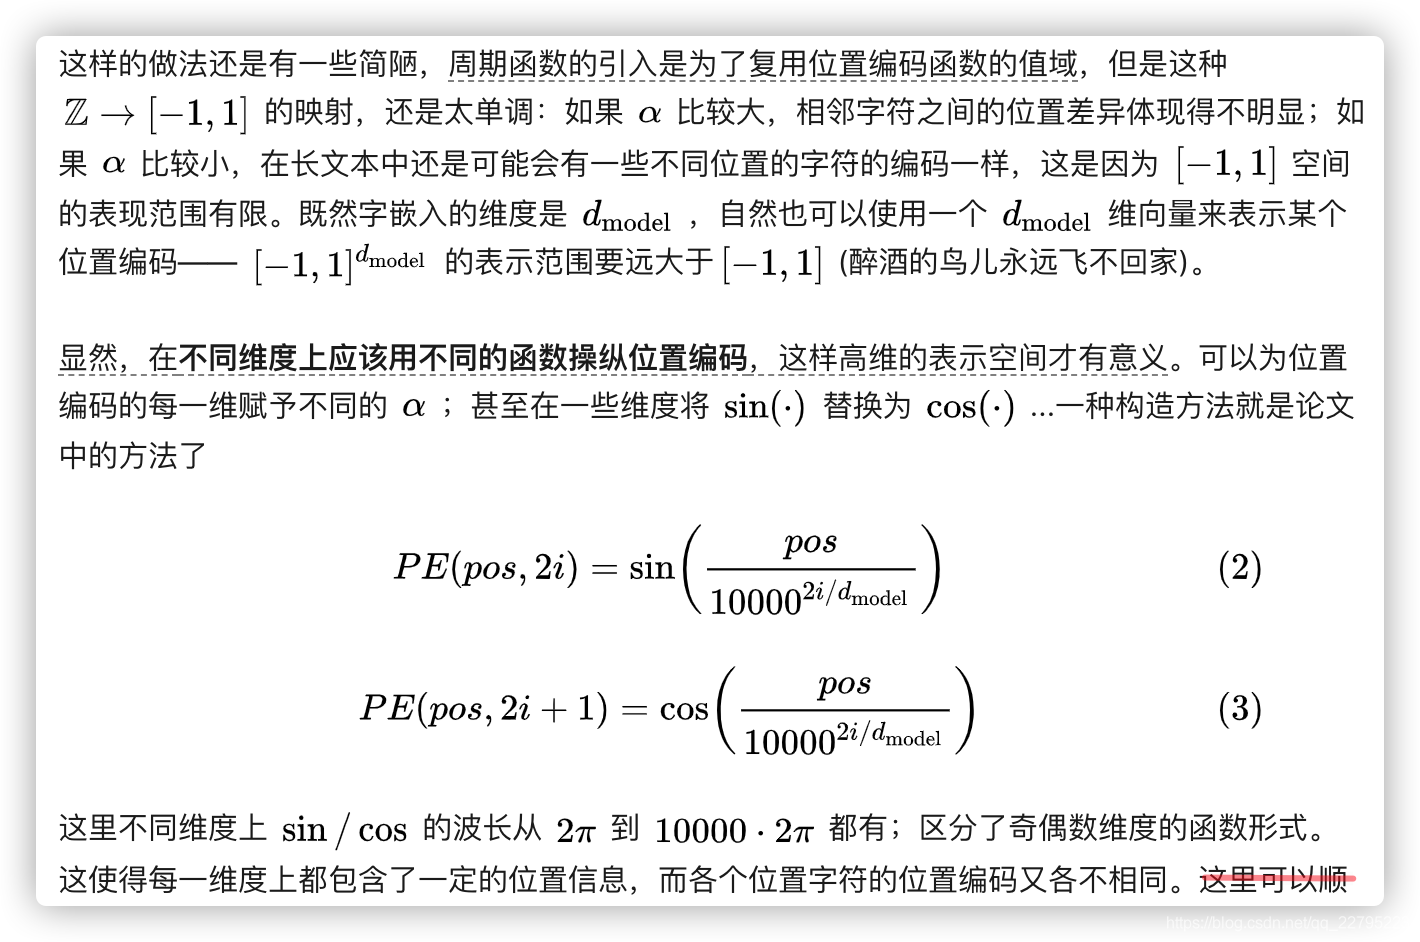

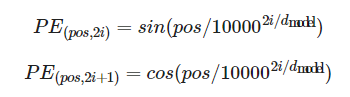

In [21]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1) #[max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

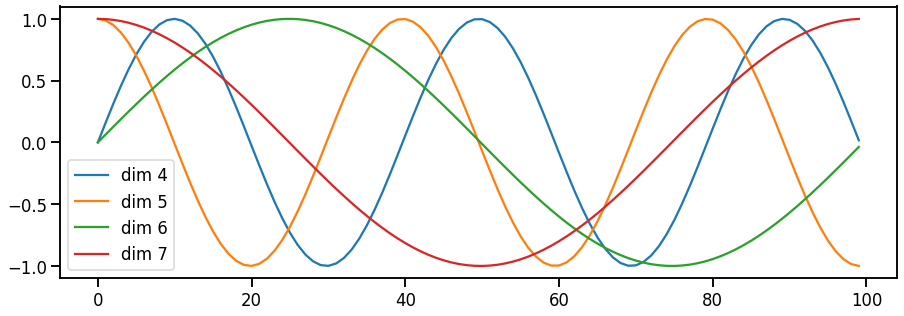

In [22]:
# 如下图，位置编码将根据位置添加正弦波。波的频率和偏移对每个维度不同
# 横坐标表示位置，纵坐标表示大小
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [23]:
# 完整模型
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

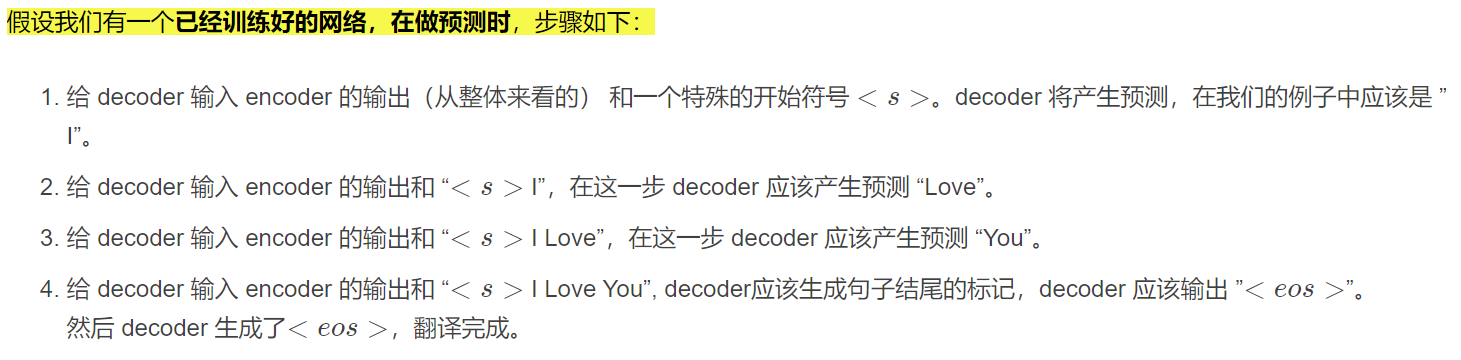

In [24]:
# 实验模型
tmp_model = make_model(10, 10, 2)
None

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [25]:
# 批处理和掩码
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [4]:
import math


def method(coins, amount):
    def recur(amount):
        if amount < 0:
            return -1
        if amount < 1:
            return 0
        min_val = math.inf
        for coin in coins:
            res = recur(amount - coin)
            if res >= 0 and res < min_val:
                min_val = res + 1
        return min_val if min_val < math.inf else -1
    return recur(amount)

print(method([1,5,7], 10))

2
